# House Price Prediction: Model 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_log_error


In [2]:
df = pd.read_csv('train.csv', index_col= 'Id')
y = df['SalePrice']

### Handling Null Values

In [4]:
df.columns[df.isna().any().tolist()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Looking at the data description,  a lot of these columns have a significant value of Na (usually means that that the house doesn't have the specificied feature), which are not just missing values.


**continuous**: MasVnrArea: mean()
Lot Frontage:  mean()
GarageYrBlt: Mode()


**Categorical** : MasVnrType:  mode()
Electrical : Mode()


**Ordinal_encoding** : 'Leave NA's for the ordinal encoding

'BsmtQual','BsmtCond', 'BsmtExposure','GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'FireplaceQu', 'BsmtFinType1', 'BsmtFinType2',

**One_hot**: Leave NA's for the OneHot Encoding

'GarageType', 'MiscFeature', 'Alley'

In [5]:
obj_nominal      = np.array(['MSSubClass','Street','Alley', 'LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','GarageType','MasVnrType','Foundation','Heating','CentralAir','SaleType','SaleCondition', 'MiscFeature'])
obj_ordinal      = np.array(['LotShape','Utilities','LandSlope', 'Fence', 'FireplaceQu','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1' ,'BsmtFinType2','HeatingQC','KitchenQual','Functional','GarageFinish','GarageQual','GarageCond','PavedDrive', 'Electrical']) # PoolQC will be converted to boolean. Electrical is ordinal 
# q stands for quantitative
obj_quantitative = np.array(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt','LotArea','OverallQual','OverallCond','MasVnrArea','BsmtFinSF1','BsmtUnfSF','BsmtFinSF2','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']) # Bigger is "better". Not found 'Bedroom','Kitchen'. Weird feature: 'BsmtFinType2'. High nan rate: 'LotFrontage'
# q_date_related   = np.array(['MoSold','YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']) #For Label encoding

#STill unclear: What do to with dates, where to put garagetype (ordinal or nominal),
#Electrical-- What to do with mix? 1 value in train, none in test

In [6]:
#Do the following, only if changing MasVnrType and GarageType NA's to 'None':
def fillNa(df):
    df['LotFrontage'].fillna(0, inplace= True)
    df['MasVnrType'].fillna('None', inplace= True) 

    df.loc[df['MasVnrType'] == 'None', ['MasVnrArea']].fillna(0, inplace= True ) #Use .loc to get rid of the Setting on Slice warning.
    df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace = True)
    
    df.loc[df['GarageType'] == 'None', ['GarageYrBlt']].fillna(0, inplace= True)
    df['GarageYrBlt'].fillna(df['GarageYrBlt'].mode()[0], inplace = True) #Fix this

    # df['Electrical'].fillna(df['Electrical'].mode(), inplace= True)
    df['Electrical'].fillna('Mix', inplace= True) #Maybe switch to mode

    df['MSSubClass'] = df['MSSubClass'].apply(str).fillna('None', inplace= True)
    df["Functional"] = df["Functional"].fillna(df.Functional.mode())
    
    return df

## Feature Engineering/Pre-processing

Preparing the Ordianl Encoding Features: 

In [7]:
def get_ordinal_features(df, obj_ordinal): #, q_date_related
  df = df.copy()
  # columns = np.concatenate((obj_ordinal, q_date_related))
  columns = obj_ordinal
  # First encoding type
  enc1_arr = np.array(['ExterQual','ExterCond','PoolQC', 'BsmtQual','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond'])
  dct1 = {np.nan :0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

  # Second encoding type
  enc2_arr = np.array(['LotShape'])
  dct2 = {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}
  enc3_arr = np.array(['BsmtFinType1', 'BsmtFinType2'])
  dct3 = {np.nan : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}

  df[enc1_arr] = df[enc1_arr].replace(dct1)
  df[enc2_arr] = df[enc2_arr].replace(dct2)
  df[enc3_arr] = df[enc3_arr].replace(dct3)

  
  df = df.replace({"Alley" : {np.nan: 0, "Grvl" : 1, "Pave" : 2},
                      "BsmtExposure" : {np.nan: 0, 'No' : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                      "Fence" : {np.nan :1, 'MnWw':2, 'GdWo':3, 'MnPrv':4, 'GdPrv':5},
                      "Electrical": {'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5},
                      	
                      "FireplaceQu" : {np.nan : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                      "Min2" : 6, "Min1" : 7, "Typ" : 8},
                      # "GarageType"
                      "GarageFinish" : {np.nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3 },
                       	
                      "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                      "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                      "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                      "Street" : {"Grvl" : 1, "Pave" : 2},
                      "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                    }
                  )
  #Date related columns
  # for c in q_date_related: 
  #   lbl = LabelEncoder() 
  #   lbl.fit(list(df[c].values)) 
  #   df[c] = lbl.transform(list(df[c].values))
  return df[columns]

Preparing the Nominal features for One-hot encoding

In [ ]:
def get_nominal_features(df, obj_nominal):
  x = df.loc[:, obj_nominal]
  x = x.astype(str) #For some reason, need to convert to string first, otherwise get an unhashable type 'Series' error.
  obj_nominal_oneHot = pd.get_dummies(data=x)
  return obj_nominal_oneHot

Now, merge all of our transformed dataframes back together

In [8]:
def process_df(df):
    filled_df = fillNa(df)
    df_train_ordinal  = get_ordinal_features(filled_df, obj_ordinal) #, q_date_related
    obj_nominal_oneHot = get_nominal_features(filled_df, obj_nominal)
    df_merge = df_train_ordinal.join([df[obj_quantitative], obj_nominal_oneHot]) #, df[q_date_related]

    return df_merge

### Feature Pre-processing Pipeline

This combines all of our pre-processing functions together. The input takes both the training set, and the testing set. We then combine them together to make sure that the transforms of the one_hot encoding are uniform, and return back the pre-processed training and testing data frames (as well as the target labels from the training set).

In [9]:
def feature_pipeline(df_train, df_test):
    
    train_idx = df_train.index
    test_idx = df_test.index
    labels = df_train.loc[:, 'SalePrice']
    df_train = df_train.drop('SalePrice', axis = 1)
    df = pd.concat([df_train, df_test])
    
    df_processed = process_df(df)
    df_train = df_processed.loc[train_idx]
    df_test = df_processed.loc[test_idx]
    return df_train, df_test, labels


In [10]:
train_df = pd.read_csv('train.csv', index_col = 'Id')
test_df = pd.read_csv('test.csv', index_col= 'Id')

df_train, df_test, labels = feature_pipeline(train_df, test_df)

Double check that there are no null values in the training set:

In [11]:
df_train.columns[df_train.isna().any().tolist()]

Index([], dtype='object')

In [12]:
df_train.loc[df_train.GarageYrBlt.isna()]

,LotShape,Utilities,LandSlope,Fence,FireplaceQu,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan
Id,,,,,,,,,,,,,,,,,,,,,


# Modeling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

#### Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
x_train, x_test, y_train, y_test = train_test_split(df_train.values, labels, test_size= 0.2, random_state= 1) #.values on df_merge just gets rid of the clunky user warning for using a Dataframe

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error


In [84]:
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)
paramaters = {'n_estimators': [100,200], #, 300, 500,1000
                'max_depth': [2, 15], #5, 8
                'min_samples_leaf' : [1],
                # 'oob_score':  [True]
                
                }
clf = GridSearchCV(RandomForestRegressor(), paramaters, n_jobs = -1, cv = 5, scoring = mse)
clf.fit(x_train, y_train)

best_rf = clf.best_estimator_.fit(x_train, y_train)
print(f'validation score with best parameters: {best_rf.score(x_test, y_test)}')
print('mean_squared_log_error', mean_squared_log_error(y_test, best_rf.predict(x_test), squared= False))

print(clf.best_params_)
# rf = RandomForestRegressor(**clf.best_params_)
# rf.fit(x_train, y_train)
# print(f'oob_score on the full training set with: {rf.oob_score_}')


validation score with best parameters: 0.9058295614577709
mean_squared_log_error 0.14149420543833613
{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}


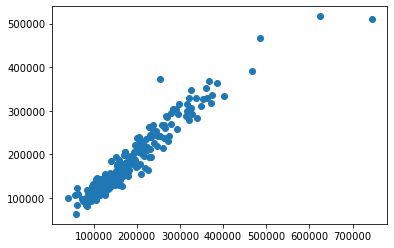

In [85]:
plt.scatter(y_test,best_rf.predict(x_test) )

#### XGBoost

In [14]:
from xgboost.sklearn import XGBRegressor

In [55]:
# paramaters = {'eta' : [0.3, 0.5, 0.8, 1.1, 1.2],
#                 'n_estimators': np.arange(100,300, step = 50), 
#                 'max_depth': [2, 4, 10, 30, 50, 100], 
#                 }
parameters = {'eta' : [0.05],
                'n_estimators': [400,450,500], 
                'max_depth': [3,4, 5], #pretty much always is 3
                'min_child_weight':  [2,3,4],
                'objective' : ['reg:gamma'],
                'colsample_bytree': [0.3,0.4, 0.5]
                }

XGB_clf = GridSearchCV(XGBRegressor(),  parameters, cv = 5, verbose= 1)
XGB_clf.fit(x_train, y_train)
print(XGB_clf.best_params_)

XG = XGBRegressor(**XGB_clf.best_params_)
XG.fit(x_train, y_train)
print(f'validation score with best parameters: {XG.score(x_test, y_test)}')
print('mean_squared_log_error', mean_squared_log_error(y_test, XG.predict(x_test), squared= False))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'colsample_bytree': 0.4, 'eta': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 450, 'objective': 'reg:gamma'}
validation score with best parameters: 0.9160217600701733
mean_squared_log_error 0.12478733604217326


In [57]:
dic = {(1,1): 2, (2,3): 4}
dic[1]

KeyError: 1

Mean squared error: 673625568.295
Coefficient of determination: 0.906


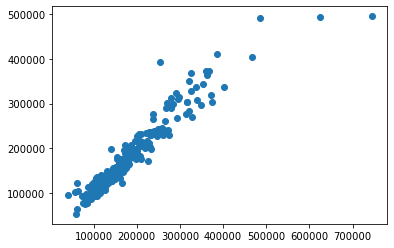

In [51]:
from sklearn.metrics import r2_score
y_test_pred = XG.predict(x_test)
plt.scatter(y_test, y_test_pred)

# The coefficients
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test,y_test_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.3f" % r2_score(y_test,y_test_pred))

In [52]:
pred = XGB.predict(df_test.values)

sample = pd.read_csv('sample_submission.csv')

sample.SalePrice = pred
sample.set_index('Id', inplace= True)
sample.to_csv('XGBoost_submission')

#### XGboost with PCA

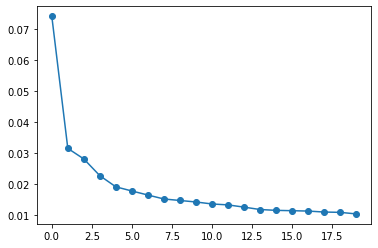

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(x_train))

x_train, x_test, y_train, y_test = train_test_split(scaled, y_train, test_size= 0.2, random_state= 42)

pca= PCA()
pca_fit = pca.fit(scaled)
plt.plot(np.arange(20), pca.explained_variance_ratio_[:20], 'o-')

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
# scaler = StandardScaler()
scaler = Normalizer()
scaled = pd.DataFrame(scaler.fit_transform(x_train))

x_train, x_test, y_train, y_test = train_test_split(scaled, y_train, test_size= 0.2, random_state= 42)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", PCA()), ("XGBRegressor", XGBRegressor(objective= 'reg:squarederror', eval_metric = 'rmse'))])
paramaters = {
        "pca__n_components": [11,12,13,14,15],
        'XGBRegressor__eta' : [0.01],
        'XGBRegressor__n_estimators': [100,150, 200,220, 250, 275], 
        'XGBRegressor__min_child_weight':  [6,7,8,9,10],

        'XGBRegressor__max_depth': [3,4, 6], 
                }

pca_cv = GridSearchCV(pipe, param_grid = paramaters, n_jobs = -1, cv = 5)
pca_cv.fit(x_train, y_train)
print(pca_cv.best_params_)

pca = pca_cv.best_estimator_.fit(x_train, y_train)
print(f'validation score with best parameters: {pca.score(x_test, y_test)}')
print('mean_squared_log_error', mean_squared_log_error(y_test, pca.predict(x_test),squared= False))


{'XGBRegressor__eta': 0.01, 'XGBRegressor__max_depth': 4, 'XGBRegressor__min_child_weight': 10, 'XGBRegressor__n_estimators': 150, 'pca__n_components': 15}
validation score with best parameters: 0.8061414526594496
mean_squared_log_error 0.1492973655286153


In [21]:
pred = XGB.predict(df_test.values)

sample = pd.read_csv('sample_submission.csv')

sample.SalePrice = pred
sample.set_index('Id', inplace= True)
sample.to_csv('XGBoost_submission')